### Import libraries and dataset

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error

# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [79]:
file_path = "../data/ObesityDataSet_Clean.csv"
df = pd.read_csv(file_path)

### Model preparation and feature engineering

In [129]:
def dataset_setup(df, all_attributes=False):
    if(all_attributes):
        X = df.drop(columns="Weight")

    else:
        #attributes_used = ["Age", "Gender", "Height", "family_history_with_overweight", "CAEC"]
        # this choice comes from the ones chosen on report 1

        attributes_used = df.drop(columns=["Weight", "FAVC", "NCP", "SMOKE", "CH2O", "SCC", "TUE"]).columns
        # testing removing this columns in particular because they were not chosen by CV when I did one hot encoding on all variables
        
        X = df[attributes_used]

    return X, df["Weight"]

#### Feature engineering
Run the cell according to the X you want to consider

1 - considering only the features from report 1\
2 - considering all features - simple one hot encoding for all\
3 - considering all features - ordinal encoding for some categorical features

In [ ]:
# considering only the features from report 1
attributes_used = ["Age", "Gender", "Height", "family_history_with_overweight", "CAEC"]
X = df[attributes_used]

X = pd.get_dummies(X, columns=["Gender", "family_history_with_overweight", "CAEC"], drop_first=True, dtype=int)

y = df["Weight"]
X.head()

Age  Height  Gender_Male  family_history_with_overweight_yes  \
0   21    1.62            0                                   1   
1   21    1.52            0                                   1   
2   23    1.80            1                                   1   
3   27    1.80            1                                   0   
4   22    1.78            1                                   0   

   CAEC_Frequently  CAEC_Sometimes  CAEC_no  
0                0               1        0  
1                0               1        0  
2                0               1        0  
3                0               1        0  
4                0               1        0

In [97]:
# considering all features - simple one hot encoding for all
X, y = dataset_setup(df, all_attributes=True)
categorical_attributes = X.drop(columns=["Age", "Height"]).columns
X = pd.get_dummies(X, columns=categorical_attributes, drop_first=True, dtype=int)

X.head()

Age  Height  Gender_Male  family_history_with_overweight_yes  FAVC_yes  \
0   21    1.62            0                                   1         0   
1   21    1.52            0                                   1         0   
2   23    1.80            1                                   1         0   
3   27    1.80            1                                   0         0   
4   22    1.78            1                                   0         0   

   FCVC_2  FCVC_3  NCP_2  NCP_3  CAEC_Frequently  ...  MTRANS_Bike  \
0       1       0      0      1                0  ...            0   
1       0       1      0      1                0  ...            0   
2       1       0      0      1                0  ...            0   
3       0       1      0      1                0  ...            0   
4       1       0      0      0                0  ...            0   

   MTRANS_Motorbike  MTRANS_Public_Transportation  MTRANS_Walking  \
0                 0                             1               0   
1                 0                             1               0   
2                 0                             1               0   
3                 0                             0               1   
4                 0                             1               0   

   NObeyesdad_Normal_Weight  NObeyesdad_Obesity_Type_I  \
0                         1                          0   
1                         1                          0   
2                         1                          0   
3                         0                          0   
4                         0                          0   

   NObeyesdad_Obesity_Type_II  NObeyesdad_Obesity_Type_III  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   NObeyesdad_Overweight_Level_I  NObeyesdad_Overweight_Level_II  
0                              0                               0  
1                              0                               0  
2                              0                               0  
3                              1                               0  
4                              0                               1  

[5 rows x 34 columns]

In [133]:
# considering all features - ordinal encoding for some categorical features

# FHWO, FAVC, SMOKE, SCC = 0/1, yes = 1, no = 0 - usar replace nestas variáveis para substituir o yes e o no por 1 e 0
# FCVC = 1/2/3 - manter
# NCP = 1/2/3 - manter
# MTRANS = One Hot Encoding
# NObeyesdad = substituir a ordem por [1, 2, 3, 4, 5, 6, 7]
# ordem ["Insufficient Weight", "Normal Weight", "Overweright_Level_I", "Overweight_Level_2", "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"]

X, y = dataset_setup(df, all_attributes=False)

ordinal_mappings = {
    "NObeyesdad": {
        "Insufficient_Weight": 1,
        "Normal_Weight": 2,
        "Overweight_Level_I": 3,
        "Overweight_Level_II": 4,
        "Obesity_Type_I": 5,
        "Obesity_Type_II": 6,
        "Obesity_Type_III": 7
    },
    "FAVC": {
        "yes": 1,
        "no": 0
    },
    "SMOKE": {
        "yes": 1,
        "no": 0
    },
    "SCC": {
        "yes": 1,
        "no": 0
    },
    "family_history_with_overweight": {
        "yes": 1,
        "no": 0
    },
    "CAEC": {
        "no": 0,
        "Sometimes": 1,
        "Frequently": 2,
        "Always": 3
    },

    "CALC": {
        "no": 0,
        "Sometimes": 1,
        "Frequently": 2,
        "Always": 3
    },

    "Gender": {
        "Male": 0,
        "Female": 1
    }
}

for col, mapping in ordinal_mappings.items():
    if col in X.columns:
        X[col] = X[col].replace(mapping)

X = pd.get_dummies(X, columns=["MTRANS"], drop_first=True, dtype=int)

X.head()

/var/folders/_v/_kmt0c5x2bx5dfl5vpkvrcxw0000gn/T/ipykernel_66700/3686263716.py:60: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[col] = X[col].replace(mapping)
/var/folders/_v/_kmt0c5x2bx5dfl5vpkvrcxw0000gn/T/ipykernel_66700/3686263716.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].replace(mapping)


Gender  Age  Height  family_history_with_overweight  FCVC  CAEC  FAF  CALC  \
0       1   21    1.62                               1     2     1    0     0   
1       1   21    1.52                               1     3     1    3     1   
2       0   23    1.80                               1     2     1    2     2   
3       0   27    1.80                               0     3     1    2     2   
4       0   22    1.78                               0     2     1    0     1   

   NObeyesdad  MTRANS_Bike  MTRANS_Motorbike  MTRANS_Public_Transportation  \
0           2            0                 0                             1   
1           2            0                 0                             1   
2           2            0                 0                             1   
3           3            0                 0                             0   
4           4            0                 0                             1   

   MTRANS_Walking  
0               0  
1               0  
2               0  
3               1  
4               0

### Functions from exercises classes

In [136]:
def bmplot(yt, xt, X):
    """
    Function plots matrix X as image with white background, black grid lines, and dark blue for selected cells.
    """
    plt.imshow(X, interpolation="none", cmap="Blues", aspect="equal", vmin=0, vmax=1)
    plt.xticks(range(0, len(xt)), xt)
    plt.yticks(range(0, len(yt)), yt)
    plt.gca().set_facecolor("white")
    for i in range(0, len(yt)):
        plt.axhline(i - 0.5, color="black")
    for i in range(0, len(xt)):
        plt.axvline(i - 0.5, color="black")
    plt.grid(False)
    
def plot_seq_feature_results(fold_results, feature_names):
    num_folds = len(fold_results)
    
    # Final summary heatmap
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"width_ratios": [2, 1]})

    # Left: Outer test MSEs
    outer_mses = [res["outer_test_mse"] for res in fold_results]
    axes[0].bar(range(1, num_folds + 1), outer_mses, color='tab:blue')
    axes[0].set_title("Outer test MSEs per fold")
    axes[0].set_xlabel("Fold")
    axes[0].set_ylabel("Outer test MSE")
    axes[0].grid(True, axis='y')
    
    # Right: Feature usage summary
    summary = np.zeros((len(feature_names), num_folds))
    for i, res in enumerate(fold_results):
        for feat in res["features"]:
            summary[feature_names.index(feat), i] = 1

    bmplot(feature_names, range(num_folds), summary)
    axes[1].set_title("Feature usage across folds")
    axes[1].set_xlabel("Outer folds")
    axes[1].set_ylabel("Features")
    plt.tight_layout()
    plt.show()

def sequential_feature_selection(X, y, outer_folds=10, inner_folds=10, random_state=42):
    CV_outer = KFold(n_splits=outer_folds, shuffle=True, random_state=random_state)

    fold_results = []  # store per-fold feature paths & errors
    outer_test_mse = []

    for outer_train_idx, outer_test_idx in CV_outer.split(X):

        # Split X and y into training/testing data for this outer fold
        # Name them X_train_outer, X_test_outer, y_train_outer, y_test_outer
        X_train_outer, X_test_outer = X.iloc[outer_train_idx], X.iloc[outer_test_idx]
        y_train_outer, y_test_outer = y.iloc[outer_train_idx], y.iloc[outer_test_idx]

        selected_features = []
        mse_per_iteration = []
        remaining_features = list(X.columns)
        best_mse = np.inf

        # Feature addition while-loop, keep adding features until no improvement
        while remaining_features:
            feature_mse = {}

            for feat in remaining_features:
                candidate_features = selected_features + [feat]

                # inner CV
                CV_inner = KFold(n_splits=inner_folds, shuffle=True, random_state=random_state)
                inner_mse = []

                for inner_train_idx, inner_test_idx in CV_inner.split(X_train_outer):

                    # Split X_train_outer and y_train_outer into training/testing data for this inner fold.
                    # Name them X_train_inner, X_test_inner, y_train_inner, y_test_inner
                    X_train_inner, X_test_inner = X_train_outer.iloc[inner_train_idx], X_train_outer.iloc[inner_test_idx]
                    y_train_inner, y_test_inner = y_train_outer.iloc[inner_train_idx], y_train_outer.iloc[inner_test_idx]
                    
                    # Create Linear Regression model, fit, and predict on the inner sets
                    # - save predictions as y_test_inner_pred.
                    # Remember to only take the candidate_features into consideration.
                    scaler = StandardScaler()
                    X_train_inner[candidate_features] = scaler.fit_transform(X_train_inner[candidate_features])
                    X_test_inner[candidate_features] = scaler.transform(X_test_inner[candidate_features])

                    model = LinearRegression(fit_intercept=True)
                    model.fit(X_train_inner[candidate_features], y_train_inner)
                    y_test_inner_pred = model.predict(X_test_inner[candidate_features])
        
                    # Add score for this fold
                    inner_mse.append(mean_squared_error(y_test_inner, y_test_inner_pred))

                # Save average MSE with this feature added
                feature_mse[feat] = np.mean(inner_mse)

            # pick best new feature
            best_feat = min(feature_mse, key=feature_mse.get)
            best_feat_mse = feature_mse[best_feat]

            # If best feature improves MSE, add it
            if best_feat_mse < best_mse:
                selected_features.append(best_feat)
                mse_per_iteration.append(best_feat_mse)
                best_mse = best_feat_mse
                remaining_features.remove(best_feat)

            else: # No improvement - get actual test MSE for outer loop, with best feature set.
                # Create Linear Regression model, fit, and predict on the outer sets
                # - save predictions as y_test_outer_pred.
                # Remember to only take the selected_features into consideration.
                scaler = StandardScaler()
                X_train_outer[selected_features] = scaler.fit_transform(X_train_outer[selected_features])
                X_test_outer[selected_features] = scaler.transform(X_test_outer[selected_features])

                model = LinearRegression(fit_intercept=True)
                model.fit(X_train_outer[selected_features], y_train_outer)
                y_test_outer_pred = model.predict(X_test_outer[selected_features])

                outer_test_mse = mean_squared_error(y_test_outer, y_test_outer_pred)
                break # Break out of while loop

        fold_results.append({
            "mse": mse_per_iteration,
            "features": selected_features,
            "outer_test_mse": outer_test_mse
        })
    return fold_results

/var/folders/_v/_kmt0c5x2bx5dfl5vpkvrcxw0000gn/T/ipykernel_66700/3197732152.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_inner[candidate_features] = scaler.fit_transform(X_train_inner[candidate_features])
/var/folders/_v/_kmt0c5x2bx5dfl5vpkvrcxw0000gn/T/ipykernel_66700/3197732152.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_inner[candidate_features] = scaler.transform(X_test_inner[candidate_features])
/var/folders/_v/_kmt0c5x2bx5dfl5vpkvrcxw0000gn/T/ipykernel_66700/3197732152.

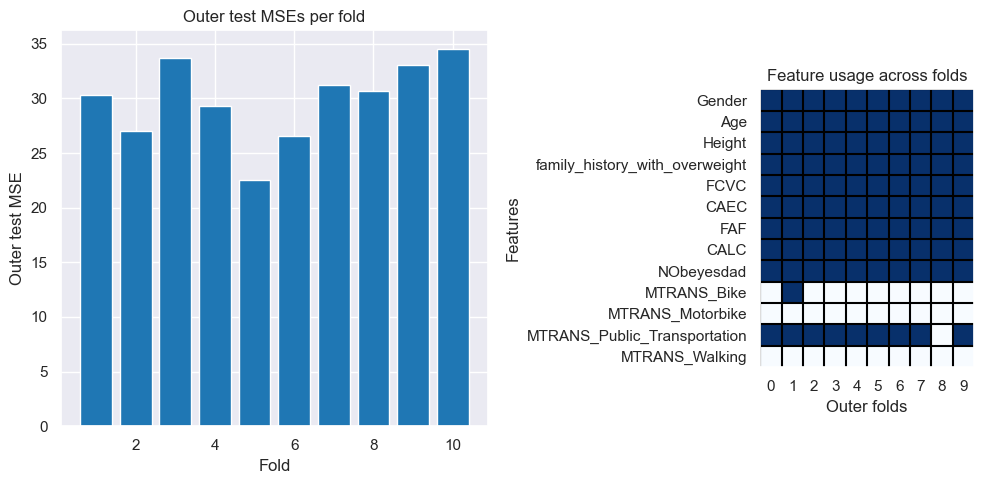

In [137]:
results = sequential_feature_selection(X, y, outer_folds=10, inner_folds=10, random_state=42)
plot_seq_feature_results(results, list(X.columns))